# **Matching Emotions: Portraits and Songs**
> ## Portrait emotion recognition
\\
The present notebook is part of our project for the course *Deep Learning*, in the context of the *Data Science* MSc. The topic of the project was open and it concerned any application that uses the basic steps of a Deep Learning system.

\\
> #### **Our team:**
- Vlachos Stefanos | dit2202dsc
- Zaragkas Efstathios | dit2203dsc

\\
>#### **Our goal:**
Our project focuses on the application of **Transfer Learning** with the aim of emotion detection in portraits and matching the portraits with a song of a similar emotion.

## **Stage 1: Transfer Learning for face emotion classification**

In the first stage of the project, we applied Transfer Learning with the aim of training a model to detect emotion in human faces. Afterwards, this model could be used to classify emotion of faces in prortrait paintings.

### **Import of necessary dependencies**

> ### Mount of Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> ### Other imports

In [ ]:
!pip install scikit-plot

import pandas as pd
import numpy as np
import scikitplot
import math
import cv2
import os

from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import DenseNet201, ResNet50, VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, GlobalAvgPool2D, GlobalMaxPool2D, Dropout, Conv2D
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall

from keras.utils import np_utils

from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix , classification_report, roc_curve, auc, roc_auc_score

from IPython.display import clear_output

## **Directories and Hyperparameters**

In [ ]:
INPUT_PATH = "/content/drive/MyDrive/Deep Learning Data/"
TRAIN_PATH = "/content/drive/MyDrive/Deep Learning Data/train/"
TEST_PATH = "/content/drive/MyDrive/Deep Learning Data/test/"
PORTRAITS_PATH = "/content/drive/MyDrive/Deep Learning Data/portraits/"

#https://towardsdatascience.com/how-to-use-random-seeds-effectively-54a4cd855a79
# A random seed used for reproducibility of the results.
SEED = 12

#https://medium.com/neuronio/how-to-deal-with-image-resizing-in-deep-learning-e5177fad7d89
#The height and width of the images used in the training or testing data.
IMG_HEIGHT = 48
IMG_WIDTH = 48
IMG_DEPTH = 3

#https://medium.com/geekculture/how-does-batch-size-impact-your-model-learning-2dd34d9fb1fa
#The number of samples/images in each batch used during the training process.
BATCH_SIZE = 128

#The number of times the training algorithm will iterate over the entire training dataset during the training process.
EPOCHS = 80

## **Data Preprocessing and Preparation**

In this stage, the available images are prepared for the training process.

> ### A view into the available images
> The annotated dataset of images used for training the target model is based on the following 7 emotions:
> * Happy
> * Sad
> * Fearful
> * Angry
> * Disgusted
> * Surprised
> * Neutral

> In its initial form, the dataset was already split into Train and Test folders. However, as it will be described later, we finally merged the two folders and carried out the train-test split process independently.

In [ ]:
print("Train Dataset includes:\n")

total_train_images = 0
for dir_ in os.listdir(TRAIN_PATH):
    count = 0
    for f in os.listdir(TRAIN_PATH + dir_ + "/"):
        count += 1
        total_train_images += 1
    print(f"{dir_}: {count} images")

print(f"\nTotal train images are {total_train_images}")

Train Dataset includes:

surprised: 3171 images
neutral: 4965 images
sad: 4835 images
fearful: 4097 images
angry: 3995 images
disgusted: 436 images
happy: 7225 images

Total train images are 28724


In [ ]:
print("Test Dataset includes:\n")

total_test_images = 0
for dir_ in os.listdir(TEST_PATH):
    count = 0
    for f in os.listdir(TEST_PATH + dir_ + "/"):
        count += 1
        total_test_images += 1
    print(f"{dir_}: {count} images")

print(f"\nTotal test images are {total_test_images}")

Test Dataset includes:

surprised: 831 images
neutral: 1233 images
disgusted: 111 images
angry: 958 images
sad: 1247 images
happy: 1774 images
fearful: 1024 images

Total test images are 7178


In [ ]:
total_images = total_train_images + total_test_images
print(f"Total number of images: {total_images}")

Total number of images: 35902


> As it is shown, the total number of images available for training the model is **35.902**. However, it can be observed that some classes are significantly undersampled (e.g. Disgusted).

> This imbalance, in addition to the fact that the differences between some emotions in the list are hardly distinguishable, could potentially **downgrade** the performance of the model.

> ### Loading images and labels into arrays
> The next step of prepartion is to load the images into **48 x 48 x 3 arrays**. Similarly, the labels of the images are loaded into an **35.902 x 1** array.


In [ ]:
total_images = 35902
img_array = np.empty(shape=(total_images, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH))
img_labels = np.empty(shape=(total_images))

In the context of the project, the aforementioned image labels are mapped to integers as follows:

| Label | Integer |
|---|---|
| angry |  0 |
| disgusted  | 1 |
| fearful |  2 |
| happy |3 |
| neutral | 4|
| sad | 5|
| surprised | 6 |

In [ ]:
label_to_text = {}
label_to_text[0] = "angry"
label_to_text[1] = "disgusted"
label_to_text[2] = "fearful"
label_to_text[3] = "happy"
label_to_text[4] = "neutral"
label_to_text[5] = "sad"
label_to_text[6] = "surprised"

print("Loading Train Images into array...\n")

i = 0
# j = 0
for dir_ in os.listdir(TRAIN_PATH):
  # label_to_text[j] = dir_
  for f in os.listdir(TRAIN_PATH + dir_ + "/"):
    img_array[i] = cv2.imread(TRAIN_PATH + dir_ + "/" + f)
    if dir_ == "angry":
      img_labels[i] = 0
    if dir_ == "disgusted":
      img_labels[i] = 1
    if dir_ == "fearful":
      img_labels[i] = 2
    if dir_ == "happy":
      img_labels[i] = 3
    if dir_ == "neutral":
      img_labels[i] = 4
    if dir_ == "sad":
      img_labels[i] = 5
    if dir_ == "surprised":
      img_labels[i] = 6
    i += 1
  print(f"loaded all {dir_} images to numpy arrays")
  # j += 1

Loading Train Images into array...

loaded all surprised images to numpy arrays
loaded all neutral images to numpy arrays
loaded all sad images to numpy arrays
loaded all fearful images to numpy arrays
loaded all angry images to numpy arrays
loaded all disgusted images to numpy arrays
loaded all happy images to numpy arrays


In [ ]:
print("Loading Test Images into array...\n")

# j = 0
for dir_ in os.listdir(TEST_PATH):
  for f in os.listdir(TEST_PATH + dir_ + "/"):
    img_array[i] = cv2.imread(TEST_PATH + dir_ + "/" + f)
    if dir_ == "angry":
      img_labels[i] = 0
    if dir_ == "disgusted":
      img_labels[i] = 1
    if dir_ == "fearful":
      img_labels[i] = 2
    if dir_ == "happy":
      img_labels[i] = 3
    if dir_ == "neutral":
      img_labels[i] = 4
    if dir_ == "sad":
      img_labels[i] = 5
    if dir_ == "surprised":
      img_labels[i] = 6
    i += 1
  print(f"Loaded all {dir_} images to numpy arrays")
  # j+=1

img_array.shape, img_labels

Loading Test Images into array...

Loaded all surprised images to numpy arrays
Loaded all neutral images to numpy arrays
Loaded all disgusted images to numpy arrays
Loaded all angry images to numpy arrays
Loaded all sad images to numpy arrays
Loaded all happy images to numpy arrays
Loaded all fearful images to numpy arrays


((35902, 48, 48, 3), array([6., 6., 6., ..., 2., 2., 2.]))

> ### Plotting available images
> Since images are loaded, we can visualise them, in order to gain a better understanding of the dataset.


<ipython-input-10-7eefdfed3bc0>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = pyplot.subplot(7,4,idx)


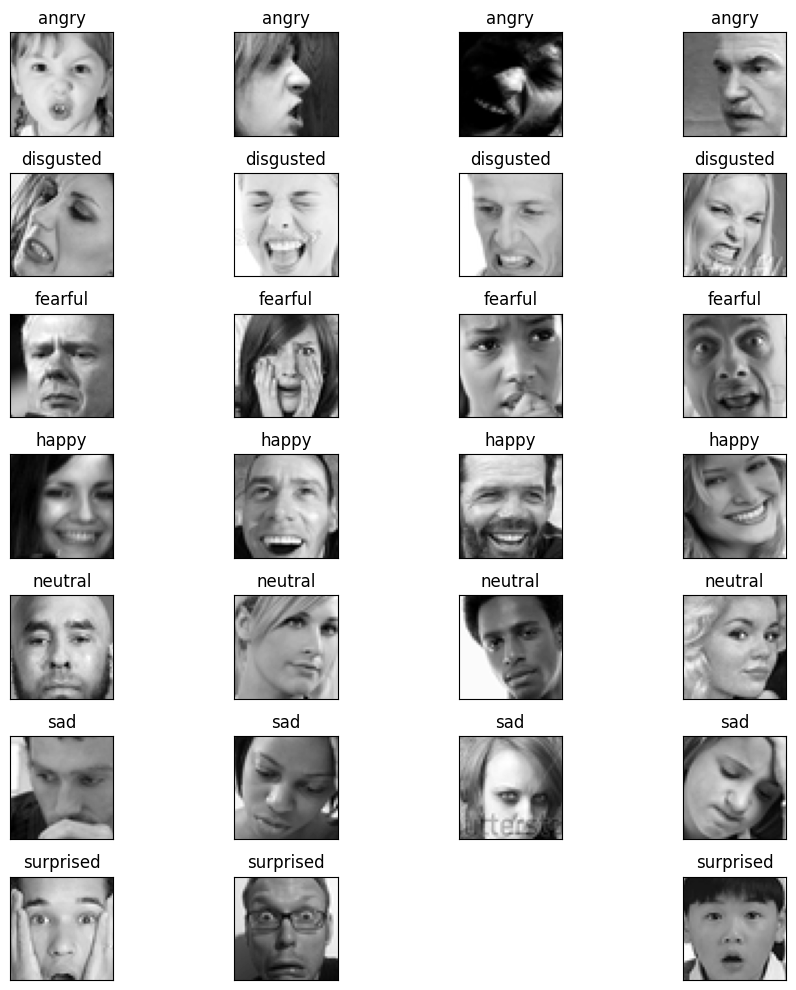

In [ ]:
fig = pyplot.figure(1, (10,10))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_labels==k)[0], size=4, replace=False)
    sample_images = img_array[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(7,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

> ### Replacing emotion labels with quadrants
As it was claimed earlier, the plotted images prove that some emotions show little diferences visually (angry-sad, fearful-surprised). This fact could potentially reduce the ability of the model to distinguish different emotions.

> Additionally, in order to be able to match the emotion of a portrait with that of a song, a common set of annotations should be used for the two modalities.

> To this end, the work in [Link](https://www.researchgate.net/\publication/353601962_Class-Based_Analysis_of_Russell's_Four-Quadrant_Emotion_Prediction_in_Virtual_Reality_using_Multi-Layer_Feedforward_ANNs) was deemed quite useful. In more detail, the classification of emotions into 4 quadrants is proposed. This paper supports that emotions could be categorized into 4 quadrants (Q1, Q2, Q3 and Q4), based on valence and arousal. Moving towards the positive values of the X axis, the perceived emotion gets more positive, while moving upwards the Y axis leads to emotions with more intensity.

> Therefore, the given annotations could be categorized as follows:

| Emotion | Quadrant |
|---|---|
| angry |  Q2 |
| disgusted | Q2, Q3 |
| fearful |  Q2 |
| happy | Q1 |
| neutral | N |
| sad | Q3 |
| surprised | Q2 |

> It is worth noticing that the emotion of disgust is located at the transition point from the 2nd to the 3rd quarter, thus, the corresponding images were divided into Q2 and Q3. Additionally, since it was noticed that most of the images annotated as surprised seemed quite fearful, images representing surprise were categorized as Q2, while no images were categorized as Q4. Finally, neutral could not be categorized to any of the quadrants, so an additional class N was created.








In [ ]:
quadrant_img_labels = np.empty(shape=(total_images))
import random

index = 0
for i in img_labels:
  if int(i) == 4:
    quadrant_img_labels[index] = 0
  if int(i) == 3:
    quadrant_img_labels[index] = 1
  if int(i)==0 or int(i)==2 or int(i) == 6:
    quadrant_img_labels[index] = 2
  if int(i)==1:
    chance = random.uniform(0, 1)
    if(chance > 0.5):
      quadrant_img_labels[index] = 2
    else:
      quadrant_img_labels[index] = 3
  if int(i) == 5:
    quadrant_img_labels[index] = 3
  index+=1;

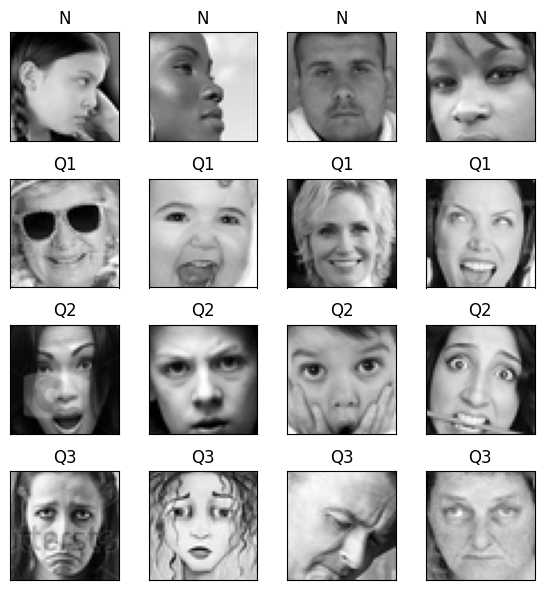

In [ ]:
quadrant_label_to_text = {}
quadrant_label_to_text[0] = "N"
quadrant_label_to_text[1] = "Q1"
quadrant_label_to_text[2] = "Q2"
quadrant_label_to_text[3] = "Q3"

fig = pyplot.figure(1, (6, 6))

idx = 0
for k in quadrant_label_to_text:
  sample_indices = np.random.choice(np.where(quadrant_img_labels==k)[0], size=4, replace=False)
  sample_images = img_array[sample_indices]
  for img in sample_images:
      idx += 1
      ax = pyplot.subplot(4,4,idx)
      ax.imshow(img[:,:,0], cmap='gray')
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_title(quadrant_label_to_text[k])
      pyplot.tight_layout()

> ### One-Hot encoding of labels
> Since labels do not have an inherent numerical order or hierarchy, **one-hot encoding** was applied for transforming categorical labels into numerical format

In [ ]:
img_labels_encoded = np_utils.to_categorical(img_labels)
img_labels_encoded.shape

(35902, 7)

In [ ]:
quadrant_img_labels_encoded = np_utils.to_categorical(quadrant_img_labels)
quadrant_img_labels_encoded.shape

(35902, 4)

> ### Images Normalization
> Normalizing photos in deep learning is an important preprocessing step, since ensuring that all images have a **consistent scale** can aid the model in **faster convergence**.

In [ ]:
img_array_normalized = img_array / 255.

> ### Train-Validation-Test Split
> As mentioned earlier, the given train and test datasets were merged and split again independently, in order to ensure that splits are **shuffled** and **balanced** in terms of class frequencies.

> The images were split as follows:

> * **Train Set**: 70%
> * **Validation Set**: 20%
> * **Test Set**: 10%

In [ ]:
# Code for quadrant labels
X_train, X_test, y_train, y_test = train_test_split(img_array_normalized, quadrant_img_labels_encoded,
                                                    shuffle=True, stratify=quadrant_img_labels_encoded,
                                                    train_size=0.9, random_state=42)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    shuffle=True, stratify=y_train,
    train_size=0.8, random_state=42
)

print("Shapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)

Shapes:
X_train: (25848, 48, 48, 3)
X_val: (6463, 48, 48, 3)
X_test: (3591, 48, 48, 3)
y_train: (25848, 4)
y_val: (6463, 4)
y_test: (3591, 4)


> ### Data Augmentation
> Data augmentation can help increase the **diversity** and **quantity** of training data without the need for collecting new labeled samples. The **[ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)** allows the generation of augmented versions of images during training, saving memory and computational resources.

> ImageDataGenerator was configured to apply the following transformations to the training data:

> * **rotation_range:** image roation
> * **shear_range:** shearing transformations
> * **zoom_range:** zoom transformation
> * **horizontal_flip:** horizontal flipping

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True,
    zca_whitening = False
)
train_datagen.fit(X_train)

## **Model Training**



In [ ]:
IMG_WIDTH = X_train.shape[1]
IMG_HEIGHT = X_train.shape[2]
IMG_DEPTH = X_train.shape[3]
NUM_CLASSES = y_train.shape[1]

print(f"Image Width: {IMG_WIDTH}")
print(f"Image Height: {IMG_HEIGHT}")
print(f"Image Depth: {IMG_DEPTH}")
print(f"Number of classes: {NUM_CLASSES}")

Image Width: 48
Image Height: 48
Image Depth: 3
Number of classes: 4


> ### Construct model using MobileNet

In [ ]:
mobile_net = MobileNet(
    input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH),
    include_top = False,
    weights = "imagenet",
    classes = NUM_CLASSES
)

x = mobile_net.output
x = GlobalMaxPool2D(name="global_pool")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
out = Dense(NUM_CLASSES, activation="softmax", name="out_layer")(x)

model = Model(inputs=mobile_net.input, outputs=out)

for layer in model.layers[:13]:
    layer.trainable = False

17225924/17225924 [==============================] - 2s 0us/step


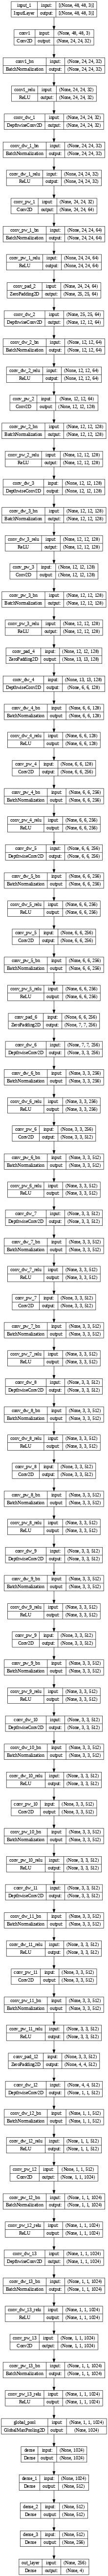

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

> ### Configure Callbacks for training

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=8,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

model_checkpoint = ModelCheckpoint('Final Model.hdf5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max')

callbacks = [
    early_stopping,
    lr_scheduler,
    model_checkpoint
]

> ### Assemble model

In [ ]:
from keras import backend as K

BATCH_SIZE = 64
EPOCHS = 80
LR = 0.001

optims = [
  optimizers.Adam(LR)
]

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(
  loss='categorical_crossentropy',
  optimizer=optims[0],
  metrics=['accuracy', f1_m]
)

> ### Model Training

In [ ]:
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) / BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/80


<ipython-input-24-8caaf82278bf>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


404/403 [==============================] - ETA: 0s - loss: 1.1247 - accuracy: 0.5081 - f1_m: 0.3827
Epoch 1: val_accuracy improved from -inf to 0.57636, saving model to Final Model.hdf5
403/403 [==============================] - 53s 73ms/step - loss: 1.1247 - accuracy: 0.5081 - f1_m: 0.3827 - val_loss: 1.0130 - val_accuracy: 0.5764 - val_f1_m: 0.5058 - lr: 0.0010
Epoch 2/80
404/403 [==============================] - ETA: 0s - loss: 0.9731 - accuracy: 0.5879 - f1_m: 0.5074
Epoch 2: val_accuracy improved from 0.57636 to 0.60560, saving model to Final Model.hdf5
403/403 [==============================] - 28s 70ms/step - loss: 0.9731 - accuracy: 0.5879 - f1_m: 0.5074 - val_loss: 0.9049 - val_accuracy: 0.6056 - val_f1_m: 0.5483 - lr: 0.0010
Epoch 3/80
404/403 [==============================] - ETA: 0s - loss: 0.9197 - accuracy: 0.6163 - f1_m: 0.5541
Epoch 3: val_accuracy did not improve from 0.60560
403/403 [==============================] - 29s 70ms/step - loss: 0.9197 - accuracy: 0.6163 -

> ### Training Results

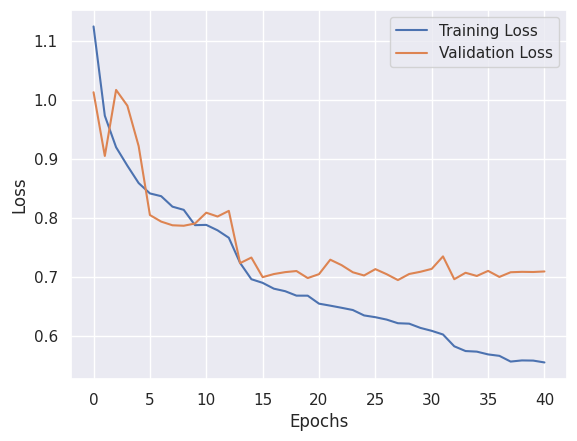

In [ ]:
# Access the training history from the 'history' object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_f1 = history.history['f1_m']
validation_f1 = history.history['val_f1_m']

# Plot the training and validation loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

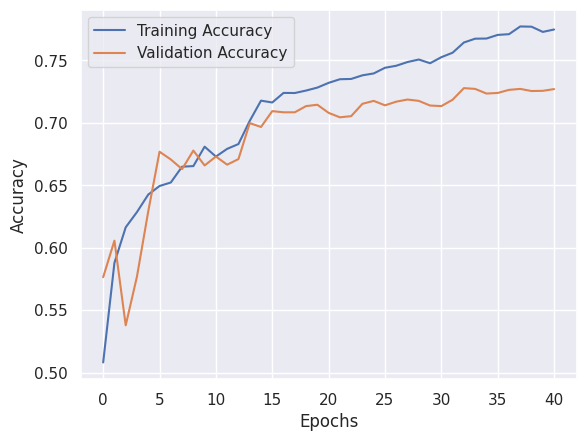

In [ ]:
# Plot the training and validation accuracy
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

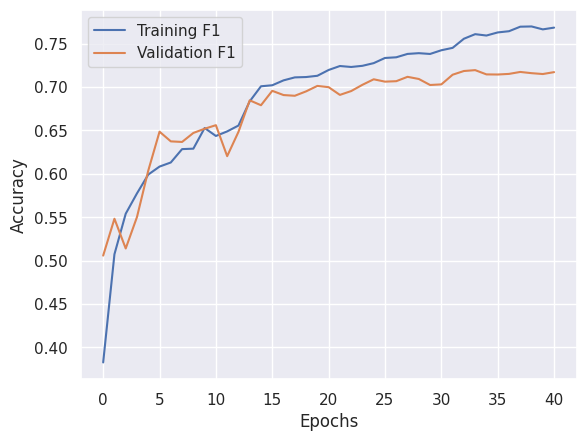

In [ ]:
# Plot the training and validation accuracy
plt.plot(training_f1, label='Training F1')
plt.plot(validation_f1, label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

> ### Model Evaluation

In [ ]:
test_loss, test_accuracy, test_f1 = model.evaluate(X_test, y_test)

113/113 [==============================] - 1s 7ms/step - loss: 0.7021 - accuracy: 0.7204 - f1_m: 0.7122


113/113 [==============================] - 1s 5ms/step
test accuracy: 72.0412 %


              precision    recall  f1-score   support

           0       0.57      0.65      0.61       620
           1       0.88      0.83      0.86       900
           2       0.75      0.78      0.77      1435
           3       0.58      0.50      0.54       636

    accuracy                           0.72      3591
   macro avg       0.70      0.69      0.69      3591
weighted avg       0.72      0.72      0.72      3591



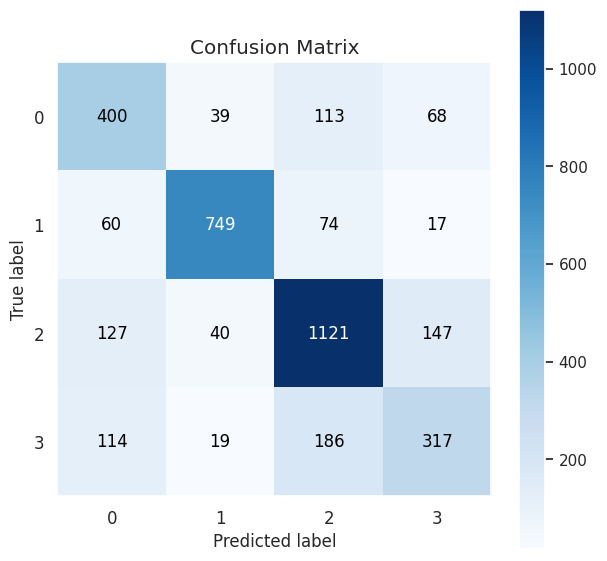

In [ ]:
y_pred_arg = np.argmax(model.predict(X_test), axis=1)
y_test_arg = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(y_test_arg, y_pred_arg, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(y_test_arg == y_pred_arg) / len(y_test_arg) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(y_test_arg, y_pred_arg))

## **Stage 2: Face Detection in Portraits**

By using the MTCNN (Multi-task Cascaded Convolutional Networks) we can extract faces from an image. The function serves the purpose of extracting facial regions from input image files. The code begins by loading the image file, converting it into a NumPy array representing the pixel values. Employing the MTCNN model, the code detects faces within the image and retrieves the bounding box coordinates enclosing the identified faces. By selecting the bounding box coordinates of the first detected face, a specific facial region is extracted from the original image. This extracted region is then converted into a PIL (Python Imaging Library) Image object, facilitating subsequent image manipulation operations. The code further resizes the face image to a predefined size while preserving its aspect ratio. Finally, the resized face image is converted back into a NumPy array and returned as the output of the function. The presented code snippet serves as a valuable tool for face-related applications, including but not limited to face recognition and emotion detection.


In [ ]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 56.8 MB/s eta 0:00:00


In [ ]:
import mtcnn
from mtcnn.mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from numpy import asarray
from PIL import Image


def extract_face(filename, required_size=(48, 48)):
    pixels = pyplot.imread(filename)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

1/1 [==============================] - 0s 129ms/step


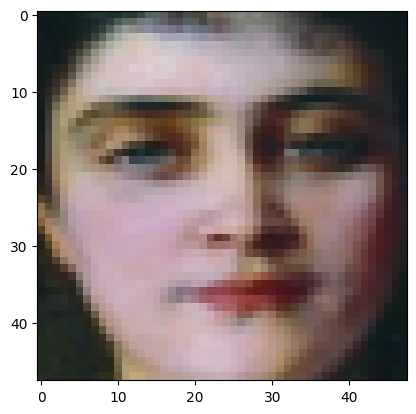

In [ ]:
pixels = extract_face('/content/drive/MyDrive/Deep Learning Data/portraits/portraits/c7cbd328622c2a4a3875e41d16212cd4c.jpg')
image = Image.fromarray(pixels, 'RGB')
image.save("/content/drive/MyDrive/Deep Learning Data/portraits/portraits_faces/0a53efb19a9b4562738d57159654ee6fc.jpg")
pyplot.imshow(pixels)
pyplot.show()

In [ ]:
import os
directory = '/content/drive/MyDrive/Deep Learning Data/portraits/portraits'

# iterate over portraits and extract just faces
for pic_name in os.listdir(directory):
    try:
        pixels = extract_face("/content/drive/MyDrive/Deep Learning Data/portraits/portraits/" + pic_name)
        image = Image.fromarray(pixels, 'RGB')
        image.save("/content/drive/MyDrive/Deep Learning Data/portraits/portraits_faces/" + pic_name)
    except IndexError:
        pass

1/1 [==============================] - 0s 229ms/step


1/1 [==============================] - 0s 492ms/step


2/2 [==============================] - 0s 8ms/step


ValueError: ignored

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the model from a folder
model_path = '/content/drive/MyDrive/models/mobilenet_model_4_bs64_quad.hdf5'
loaded_model = tf.keras.models.load_model(model_path)

# Load and preprocess the image
image_path = '/content/drive/MyDrive/Deep Learning Data/portraits/portraits_faces/dc07318648243e24a921928e80c21629c.jpg'
image = Image.open(image_path)
image = image.resize((48, 48))
image = np.array(image) / 255.0  # Normalize the image
predictions = loaded_model.predict(np.expand_dims(image, axis=0))
predicted_class_index = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 387ms/step


In [ ]:
labels = {0: 'Q1', 1: 'N', 2: 'Q3', 3: 'Q2'}
predicted_labels = [labels[k] for k in predicted_class_index]
print(predicted_labels)

['Q1']
